# Parcial 1 - DEFI 4


## 1) Estimación de Ventas en el Mes 24

Una cadena de retail desea estimar las ventas en el mes 24 de sus tiendas a partir de información geográfica, sociodemográfica y de competencia. El objetivo es identificar qué factores impulsan las ventas y poder predecir el comportamiento de nuevas tiendas.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Librerias
##  Manipulación de datos
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt

# Ramdom Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor                         # Random Forest de regresión
from sklearn.compose import ColumnTransformer                              # Preprocesamiento por tipo de columna
from sklearn.preprocessing import OneHotEncoder, StandardScaler                           # One-hot para variables categóricas
from sklearn.pipeline import Pipeline                                      # Encadenar preprocesamiento + modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
tiendas_100 = pd.read_csv("Punto1.tiendas_100.csv")
tiendas_100.head()

,Tienda,lat,lon,store_cat,pop_100m,pop_300m,pop_500m,commerces,gas_stations,malls,foot_traffic,car_traffic,socio_level,viviendas_100m,oficinas_100m,viviendas_pobreza,competencia,tiendas_peq,ventas_m24
0,Tienda_1,4.749160,-74.093470,super,334.954549,444.107181,870.751484,12,0,0,50.000000,95.880873,4,252,72,16,49,1,1969.643815
1,Tienda_2,4.691439,-74.039200,express,283.656524,278.719607,893.404683,1,3,0,62.977613,159.508346,4,321,5,70,10,1,1629.323937
2,Tienda_3,4.696289,-74.056088,express,468.458855,1014.339391,1210.112342,19,1,0,164.964682,157.989764,2,384,86,89,24,23,3157.325481
3,Tienda_4,4.645151,-74.068723,super,155.305253,387.144490,644.736732,1,0,0,116.989339,80.000000,2,50,10,8,39,1,523.747234
4,Tienda_5,4.724383,-74.110199,express,249.117040,596.660625,1056.627802,4,0,0,88.726161,80.000000,2,166,74,37,41,14,2377.258893


In [3]:
# Definimos variables explicativas (X) y objetivo (y)
feature_cols = [
    'lat', 'lon', 'store_cat', 'pop_100m', 'pop_300m', 'pop_500m',
    'commerces', 'gas_stations', 'malls', 'foot_traffic', 'car_traffic',
    'socio_level', 'viviendas_100m', 'oficinas_100m', 'viviendas_pobreza',
    'competencia', 'tiendas_peq']
X = tiendas_100[feature_cols].copy()
y = tiendas_100["ventas_m24"].copy()

# Separar entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=28)

In [4]:
# Preprocesamiento: One-Hot para la variable categórica

cat_features = ["store_cat"]
num_features = [c for c in feature_cols if c not in cat_features]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features)
    ]
)

In [5]:
#--------
# 5. MODELO 1: Random Forest Regressor
# --------
rf = RandomForestRegressor(
    n_estimators=960,        # número de árboles
    max_depth=None,         # dejar crecer y que el ensamble controle varianza
    min_samples_leaf=2,     # hojas mínimas para suavizar
    max_features="sqrt",    # submuestreo de variables por split
    random_state=42,
    n_jobs=-1               # usar todos los núcleos disponibles
)

pipe_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf)
])

# Entrenar RF
pipe_rf.fit(X_train, y_train)

# Predicciones y métricas
y_pred_rf = pipe_rf.predict(X_test)
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf)
# MAPE
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100


print("\n=== Random Forest Regressor ===")
print(f"MAE  : {mae_rf:,.0f}")
print(f"RMSE : {rmse_rf:,.0f}")
print(f"R²   : {r2_rf:,.4f}")
print(f"MAPE : {mape_rf:.2f}%")



=== Random Forest Regressor ===
MAE  : 600
RMSE : 1,087
R²   : 0.6854
MAPE : 16.22%


In [6]:
# --------
# MODELO 2: XGBoost Regressor con Búsqueda de Hiperparámetros
# --------
import numpy as np
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform

# Definir el modelo base de XGBoost
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

pipe_xgb = Pipeline(steps=[
    ("prep", preprocess),   # tu preprocesamiento definido antes
    ("model", xgb)
])

# Espacio de hiperparámetros para XGBoost
param_dist_xgb = {
    "model__n_estimators": randint(200, 1000),        # nº de árboles
    "model__max_depth": randint(3, 15),              # profundidad de cada árbol
    "model__learning_rate": uniform(0.01, 0.3),      # tasa de aprendizaje
    "model__subsample": uniform(0.5, 0.5),           # muestreo filas
    "model__colsample_bytree": uniform(0.5, 0.5),    # muestreo columnas
    "model__min_child_weight": randint(1, 10),       # regularización
    "model__gamma": uniform(0, 5)                    # reducción mínima de pérdida
}

# RandomizedSearchCV para XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=50,                # número de combinaciones aleatorias a probar
    cv=5,                     # validación cruzada 5 folds
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Entrenar búsqueda
random_search_xgb.fit(X_train, y_train)

# Mostrar mejores hiperparámetros
print("=== Mejores parámetros XGBoost ===")
print(random_search_xgb.best_params_)

# Mejor modelo optimizado
best_xgb = random_search_xgb.best_estimator_

# Predicciones con el mejor XGBoost
y_pred_xgb = best_xgb.predict(X_test)

# Métricas
mae_xgb  = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb   = r2_score(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print("\n=== XGBoost Optimizado ===")
print(f"MAE  : {mae_xgb:,.0f}")
print(f"RMSE : {rmse_xgb:,.0f}")
print(f"R²   : {r2_xgb:,.4f}")
print(f"MAPE : {mape_xgb:.2f}%")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
=== Mejores parámetros XGBoost ===
{'model__colsample_bytree': np.float64(0.662172510502637), 'model__gamma': np.float64(0.6104397735033668), 'model__learning_rate': np.float64(0.11688935142309247), 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 576, 'model__subsample': np.float64(0.8238450602706812)}

=== XGBoost Optimizado ===
MAE  : 460
RMSE : 748
R²   : 0.8511
MAPE : 13.38%


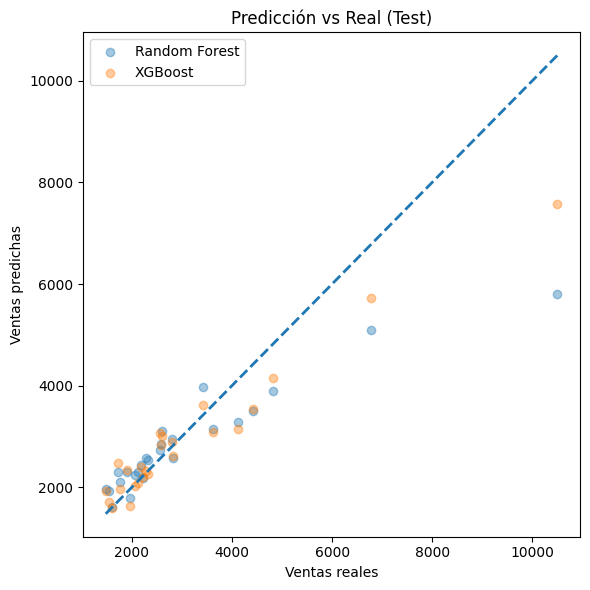

In [7]:
# --------
# Comparación visual Predicho vs Real
# --------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.4, label="Random Forest")
plt.scatter(y_test, y_pred_xgb, alpha=0.4, label="XGBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", lw=2)
plt.xlabel("Ventas reales")
plt.ylabel("Ventas predichas")
plt.title("Predicción vs Real (Test)")
plt.legend()
plt.tight_layout()
plt.show()


Top 15 importancias (Gini):
              feature  importance
6            pop_100m    0.362295
15     viviendas_100m    0.256608
8            pop_500m    0.143294
7            pop_300m    0.141548
16      oficinas_100m    0.021860
17  viviendas_pobreza    0.013176
10       gas_stations    0.011416
19        tiendas_peq    0.010360
4                 lat    0.009481
9           commerces    0.005750
18        competencia    0.005191
0   store_cat_express    0.004015
12       foot_traffic    0.002715
13        car_traffic    0.002701
14        socio_level    0.002567


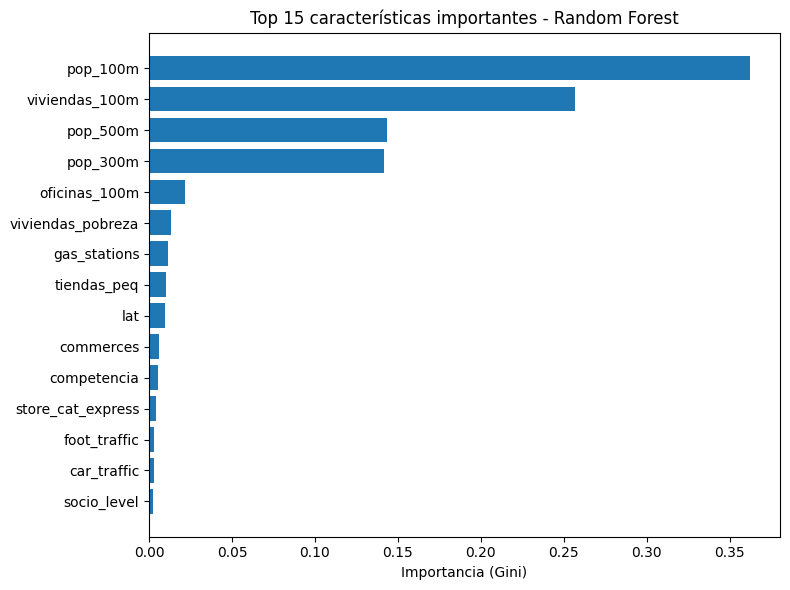

In [8]:
# Importancias de variables (Gini) desde el RF
# --------
# Obtenemos el OneHotEncoder desde el pipeline
ohe = best_xgb.named_steps["prep"].named_transformers_["cat"]
# Nombres de categorías codificadas
ohe_feature_names = ohe.get_feature_names_out(cat_features)

# Nombres finales del transformador (cat + num)
final_feature_names = list(ohe_feature_names) + num_features

# Importancias del modelo RF
importances = best_xgb.named_steps["model"].feature_importances_

# Ordenamos y graficamos
imp_df = pd.DataFrame({
    "feature": final_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 15 importancias (Gini):")
print(imp_df.head(15))

plt.figure(figsize=(8,6))
imp_head = imp_df.head(15).iloc[::-1]
plt.barh(imp_head["feature"], imp_head["importance"])
plt.xlabel("Importancia (Gini)")
plt.title("Top 15 características importantes - Random Forest")
plt.tight_layout()
plt.show()

In [9]:
## Predicciones
# Cargar el dataset nuevo (10 tiendas, sin target)
df_new = pd.read_csv("Punto1.tiendas_10_no_target.csv")
# Predecir con el modelo entrenado
y_pred_new = best_xgb.predict(df_new)
df_resultados = df_new.copy()
df_resultados["ventas_m24_pred"] = y_pred_new
print(df_resultados[["Tienda", "ventas_m24_pred"]])


       Tienda  ventas_m24_pred
0  Tienda_101      2791.448242
1  Tienda_102      2327.662842
2  Tienda_103      1363.718018
3  Tienda_104      1642.507324
4  Tienda_105      4879.599609
5  Tienda_106      1899.308960
6  Tienda_107       943.202271
7  Tienda_108      1189.590332
8  Tienda_109       990.494568
9  Tienda_110      3490.700439


## 2) Clusterización en Datos Funcionales

 La empresa desea analizar el comportamiento mensual de las ventas de las 100 tiendas para identificar patrones de transaccionalidad. Esto servirá para diseñar estrategias de crecimiento y segmentación.

In [28]:
pip install scikit-fda

In [29]:
from skfda import FDataGrid
from skfda.representation.basis import BSplineBasis
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

In [30]:
# Cargar el archivo CSV
datos = pd.read_csv("Punto2.ventas_funcionales.csv")

# Ver primeras filas
print(datos.head())

# 4. Convertir a matriz
matriz_completa = datos.values   # toda la tabla como matriz numpy

# Si la primera columna es un identificador (ej: Tienda), la quitamos
matriz_ventas = datos.iloc[:, 1:].values   # quita la columna de IDs

# # 5. (opcional, porque en tu R multiplicabas todo *2)
# matriz_ventas = matriz_ventas * 2

# 6. Guardar la matriz final
f_final = matriz_ventas

# Revisar dimensiones
print(f_final.shape)


   Periodo    Tienda_1    Tienda_2     Tienda_3    Tienda_4     Tienda_5  \
0        1  371.564749  447.247065   828.308926  211.314708   989.848606   
1        2  522.068486  530.932667   904.216563  221.842367  1062.300984   
2        3  521.880364  678.064686  1089.587200  241.279089  1066.981616   
3        4  538.892196  689.724767  1255.467374  264.903623  1293.887184   
4        5  679.219788  682.211899  1189.656722  288.745312  1257.499152   

      Tienda_6    Tienda_7    Tienda_8     Tienda_9  ...   Tienda_91  \
0  1130.512067  587.353116  193.129069   903.735902  ...  558.978290   
1  1191.000389  607.170795  210.439925  1138.634701  ...  625.641555   
2  1184.484421  643.088485  230.030267   999.554357  ...  896.016097   
3  1421.943994  700.387462  246.321533  1187.082559  ...  861.392323   
4  1456.082773  750.266504  319.294744  1672.458694  ...  850.357390   

    Tienda_92    Tienda_93   Tienda_94    Tienda_95   Tienda_96    Tienda_97  \
0  588.054490   931.256709  47

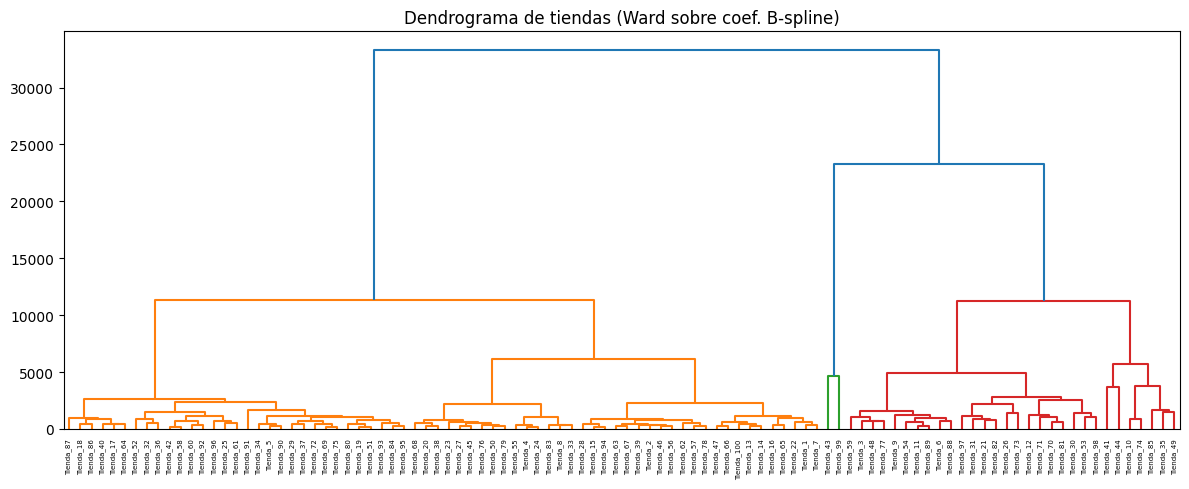

Silhouette por K: {2: np.float64(0.5458793946748185), 3: np.float64(0.5581281241023972), 4: np.float64(0.3904522564745787), 5: np.float64(0.41444898275421077), 6: np.float64(0.38843706936058914), 7: np.float64(0.37411002727906184), 8: np.float64(0.3522635221523647)}
K óptimo (silhouette): 3


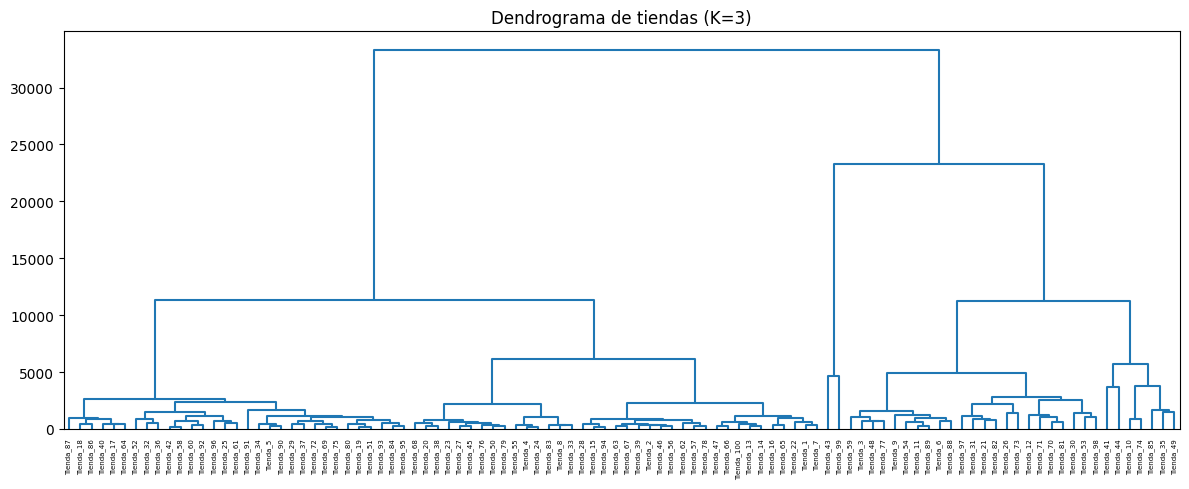

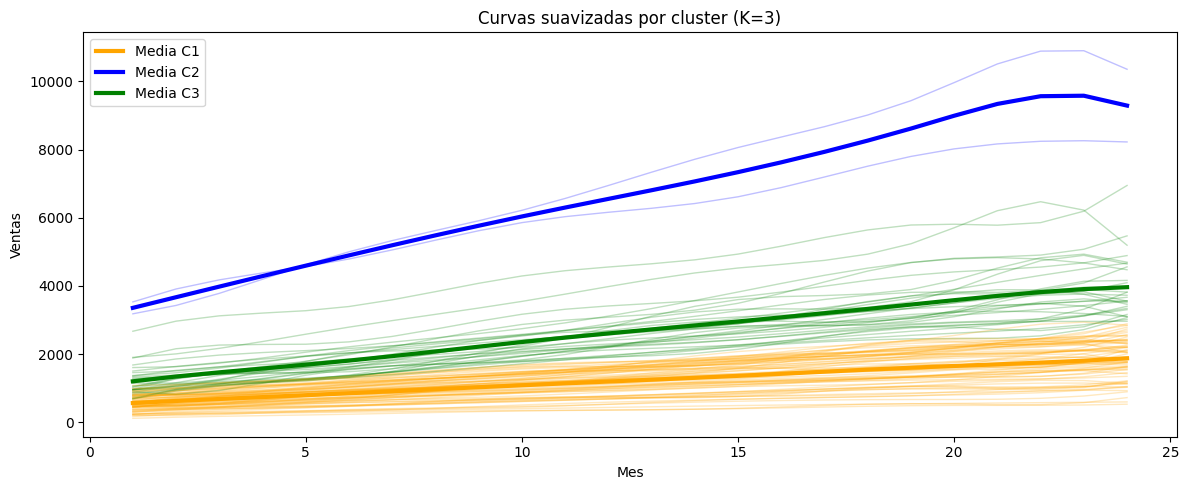

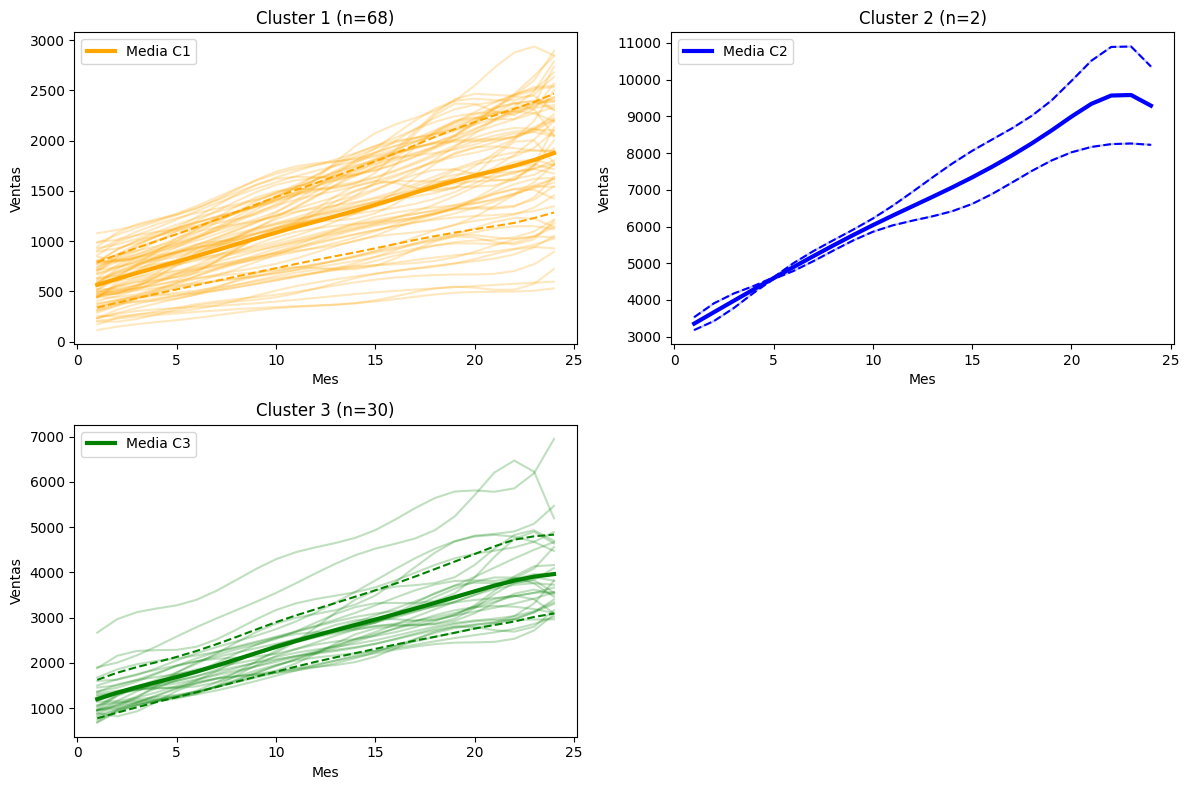

In [31]:
# ===== 1) Cargar y preparar =====
df = pd.read_csv("Punto2.ventas_funcionales.csv")
periodos = df["Periodo"].values                  # (24,)
ventas = df.drop(columns=["Periodo"]).values.T   # (100, 24) filas=tiendas

n_tiendas, n_periodos = ventas.shape
tiendas_labels = [f"Tienda_{i+1}" for i in range(n_tiendas)]
eval_points = np.arange(1, n_periodos+1)

# FDataGrid -> FDataBasis (B-spline)
basis = BSplineBasis(domain_range=(1, n_periodos), n_basis=8)
fd_grid  = FDataGrid(data_matrix=ventas, grid_points=periodos)
fd_basis = fd_grid.to_basis(basis)

# ===== 2) Dendrograma en espacio de coeficientes =====
coef = fd_basis.coefficients
dist_matrix = pdist(coef, metric="euclidean")
Z = linkage(dist_matrix, method="ward")

plt.figure(figsize=(12, 5))
dendrogram(Z, labels=tiendas_labels, leaf_rotation=90)
plt.title("Dendrograma de tiendas (Ward sobre coef. B-spline)")
plt.tight_layout()
plt.show()

# ===== 3) Elegir K con silhouette =====
sil_scores = {}
for k in range(2, 9):
    labels_k = fcluster(Z, k, criterion="maxclust")
    sil_scores[k] = silhouette_score(coef, labels_k, metric="euclidean")

K_opt = max(sil_scores, key=sil_scores.get)
print("Silhouette por K:", sil_scores)
print("K óptimo (silhouette):", K_opt)

# Si quieres fijar K=3 por tu dendrograma:
K_opt = 3
labels = fcluster(Z, K_opt, criterion="maxclust")

# ===== Definir paleta fija (colores consistentes) =====
cluster_colors = {
    1: "orange",
    2: "blue",
    3: "green"
}

# ===== 4) Dendrograma coloreado =====
plt.figure(figsize=(12,5))
dend = dendrogram(
    Z,
    labels=tiendas_labels,
    leaf_rotation=90,
    color_threshold=0
)
plt.title("Dendrograma de tiendas (K=3)")
plt.tight_layout()
plt.show()

# ===== 5) Graficar TODAS las curvas suavizadas por cluster =====
fd_eval = fd_basis(eval_points)

plt.figure(figsize=(12,5))
for i in range(n_tiendas):
    c = cluster_colors[labels[i]]
    plt.plot(eval_points, fd_eval[i], alpha=0.25, linewidth=1.0, color=c)

for k in range(1, K_opt+1):
    idx = (labels == k)
    mean_k = fd_eval[idx].mean(axis=0)
    plt.plot(eval_points, mean_k, linewidth=3, color=cluster_colors[k], label=f"Media C{k}")

plt.title(f"Curvas suavizadas por cluster (K={K_opt})")
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.legend()
plt.tight_layout()
plt.show()

# ===== 6) Panel por cluster: todas las curvas + media ± desviación =====
n_cols = 2
n_rows = int(np.ceil(K_opt / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows), squeeze=False)

for k in range(1, K_opt+1):
    ax = axes[(k-1)//n_cols, (k-1)%n_cols]
    idx = (labels == k)
    curvas_k = fd_eval[idx]
    mean_k   = curvas_k.mean(axis=0)
    std_k    = curvas_k.std(axis=0)

    for y in curvas_k:
        ax.plot(eval_points, y, alpha=0.25, color=cluster_colors[k])

    ax.plot(eval_points, mean_k, linewidth=3, label=f"Media C{k}", color=cluster_colors[k])
    ax.plot(eval_points, mean_k + std_k, linestyle="--", color=cluster_colors[k])
    ax.plot(eval_points, mean_k - std_k, linestyle="--", color=cluster_colors[k])

    ax.set_title(f"Cluster {k} (n={idx.sum()})")
    ax.set_xlabel("Mes"); ax.set_ylabel("Ventas")
    ax.legend()

# quitar ejes vacíos si K es impar
for r in range(n_rows):
    for c in range(n_cols):
        k_panel = r*n_cols + c + 1
        if k_panel > K_opt:
            fig.delaxes(axes[r, c])

plt.tight_layout()
plt.show()


In [32]:
import numpy as np
import pandas as pd

# 1) Identificar el cluster más representativo (más frecuente)
cluster_mas_rep = np.bincount(labels).argmax()
print(f"Cluster más representativo: {cluster_mas_rep}")

# 2) Filtrar las tiendas que pertenecen a ese cluster
tiendas_cluster = ventas[labels == cluster_mas_rep]

# 3) Calcular la curva promedio (ventas medias mes a mes)
promedio_cluster = tiendas_cluster.mean(axis=0)

# 4) Estimación de ventas para Tienda_101 (mes 1 a 24)
ventas_tienda101 = promedio_cluster

# 5) Convertimos en DataFrame para tu entregable en Sheets
df_estimacion = pd.DataFrame({
    "Mes": np.arange(1, 25),
    "Ventas_Tienda101": ventas_tienda101
})

print(df_estimacion)


Cluster más representativo: 1
    Mes  Ventas_Tienda101
0     1        563.556969
1     2        623.319857
2     3        681.330959
3     4        743.456593
4     5        785.168044
5     6        857.737355
6     7        905.392015
7     8        967.127225
8     9       1027.212537
9    10       1092.941867
10   11       1124.245833
11   12       1201.560159
12   13       1253.914529
13   14       1288.687053
14   15       1370.853672
15   16       1435.561793
16   17       1474.457863
17   18       1517.968752
18   19       1604.775313
19   20       1671.844089
20   21       1688.468706
21   22       1762.771746
22   23       1786.989661
23   24       1883.368230


Cluster asignado a Tienda_101: 1
    Mes  Venta_estimada
19   20     2456.150688
20   21     2527.935357
21   22     2602.591229
22   23     2687.851219
23   24     2791.448242


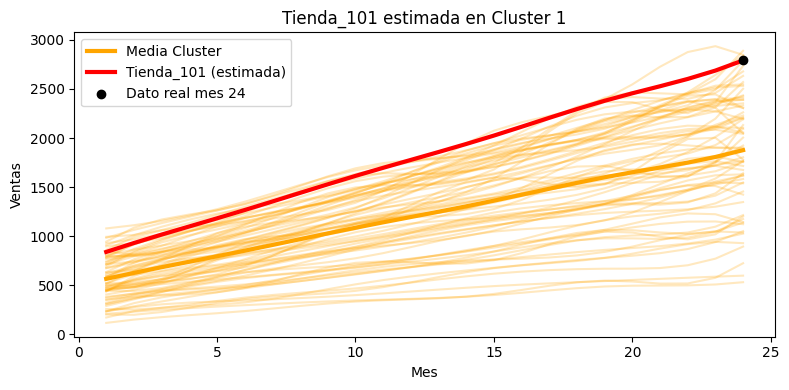

In [34]:
# ========= 1) Cluster de referencia para la nueva tienda =========
# Por ejemplo, supongamos que ya sabes (o decides) que la Tienda_101 pertenece al cluster 1
cluster_tienda101 = 1
print("Cluster asignado a Tienda_101:", cluster_tienda101)

# ========= 2) Patrón del cluster =========
idx_cluster = (labels == cluster_tienda101)
curvas_cluster = fd_eval[idx_cluster]

# Media del cluster (24 meses)
mean_cluster = curvas_cluster.mean(axis=0)

# ========= 3) Ajustar al valor conocido en mes 24 =========
ventas_mes24_real = 2791.448242
factor_escalado = ventas_mes24_real / mean_cluster[-1]

estimacion_tienda101 = mean_cluster * factor_escalado
# ========= 4) Crear DataFrame con la serie estimada =========
df_tienda101 = pd.DataFrame({
    "Mes": eval_points,
    "Venta_estimada": np.ravel(estimacion_tienda101)  # 🔑 aplana array a 1D
})



# ========= 5) Graficar comparación =========
plt.figure(figsize=(8,4))

# Todas las curvas del cluster
for y in curvas_cluster:
    plt.plot(eval_points, y, alpha=0.25, color=cluster_colors[cluster_tienda101])

# Media del cluster
plt.plot(eval_points, mean_cluster, linewidth=3, color=cluster_colors[cluster_tienda101], label="Media Cluster")

# Estimación ajustada para Tienda_101
plt.plot(eval_points, estimacion_tienda101, linewidth=3, color="red", label="Tienda_101 (estimada)")

plt.scatter(24, ventas_mes24_real, color="black", zorder=5, label="Dato real mes 24")

plt.title(f"Tienda_101 estimada en Cluster {cluster_tienda101}")
plt.xlabel("Mes")
plt.ylabel("Ventas")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
print(df_tienda101)

    Mes  Venta_estimada
0     1      837.927849
1     2      928.897627
2     3     1014.884725
3     4     1098.137391
4     5     1180.903873
5     6     1265.392811
6     7     1352.273200
7     8     1440.213970
8     9     1527.750388
9    10     1613.417718
10   11     1696.039806
11   12     1776.573292
12   13     1856.930736
13   14     1939.029213
14   15     2024.778978
15   16     2114.645507
16   17     2205.870784
17   18     2295.260629
18   19     2379.620865
19   20     2456.150688
20   21     2527.935357
21   22     2602.591229
22   23     2687.851219
23   24     2791.448242


In [134]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# =============================
# 1) Datos base del cluster
# =============================
# Supongamos que "ventas_cluster" es el perfil promedio del cluster 1
# (estos datos deben venir del promedio que calculaste en tu clustering)
ventas_cluster = np.array([1200, 1500, 1800, 2000, 2100, 2200,
                           2500, 2600, 2700, 2800, 2900, 3000,
                           3100, 3200, 3300, 3400, 3500, 3600,
                           3700, 3800, 3900, 4000, 4100, 4200])

# =============================
# 2) Escalado para normalizar
# =============================
scaler = MinMaxScaler()
ventas_cluster_norm = scaler.fit_transform(ventas_cluster.reshape(-1, 1))

# =============================
# 3) Ajuste al valor real mes 24
# =============================
venta_real_mes24 = 2791.448242  # valor dado para Tienda_101

# Normalizar ventas estimadas del cluster a rango [0,1]
ventas_cluster_norm = ventas_cluster_norm.ravel()

# Escalar al rango real
ventas_cluster_escaladas = ventas_cluster_norm * venta_real_mes24 / ventas_cluster_norm[-1]

# =============================
# 4) Crear DataFrame final
# =============================
df_tienda101 = pd.DataFrame({
    "Mes": np.arange(1, 25),
    "Venta_estimada": ventas_cluster_escaladas
})

print(df_tienda101)


    Mes  Venta_estimada
0     1        0.000000
1     2      279.144824
2     3      558.289648
3     4      744.386198
4     5      837.434473
5     6      930.482747
6     7     1209.627572
7     8     1302.675846
8     9     1395.724121
9    10     1488.772396
10   11     1581.820670
11   12     1674.868945
12   13     1767.917220
13   14     1860.965495
14   15     1954.013769
15   16     2047.062044
16   17     2140.110319
17   18     2233.158594
18   19     2326.206868
19   20     2419.255143
20   21     2512.303418
21   22     2605.351693
22   23     2698.399967
23   24     2791.448242


## 3) Estimación de Transacciones de un Producto Financiero

Una oficina financiera desea pronosticar el uso del dinero (valor total) de un producto financiero. Para ello se dispone de la información de los meses de julio a octubre 2022 y se busca estimar los valores de noviembre 2022.

In [13]:
!pip -q install prophet holidays

In [14]:
from prophet import Prophet                    # Modelo Prophet
from prophet.diagnostics import cross_validation, performance_metrics  # CV y métricas
from prophet.plot import plot_cross_validation_metric                  # Gráfico de métricas en CV


In [15]:
datos = pd.read_csv("Punto3.SerieUsodeldinero.csv")
# Formato requerido por Prophet
df = datos.rename(columns={
    "fecha": "ds",
    "valor_total_millones": "y"
})

df.head()


,ds,valor_total,y,valor_total_millones_div5
0,2022-07-01,5.587159e+10,55871.592578,11174.318516
1,2022-07-02,1.056773e+10,10567.733300,2113.546660
2,2022-07-03,1.047493e+08,104.749304,20.949861
3,2022-07-05,3.409717e+10,34097.174855,6819.434971
4,2022-07-06,4.072937e+10,40729.368277,8145.873655


In [16]:
# ===========================================
# 4) CONSTRUCCIÓN DEL MODELO PROPHET
# ===========================================
# Parámetros clave:
#   - yearly_seasonality, weekly_seasonality: estacionalidades por defecto
#   - seasonality_mode: 'additive' o 'multiplicative' (si la variación escala con el nivel)
#   - changepoint_prior_scale: sensibilidad a cambios de tendencia (prueba 0.05, 0.1, 0.5)
#   - seasonality_prior_scale: regularización sobre estacionalidades (por defecto 10)
#   - holidays: pasamos nuestros eventos propios
m = Prophet(
    weekly_seasonality=True,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=10
)

# Agregamos feriados oficiales de Colombia (además de nuestros eventos propios)
m.add_country_holidays(country_name="CO")

# Agregamos una estacionalidad MENSUAL personalizada (periodo ~30.5 días)
#   fourier_order controla la complejidad/ondulación de esa estacionalidad
m.add_seasonality(name="mensual", period=30.5, fourier_order=5)


# # Declaramos regresores adicionales que existen en df (precio y promo)
# m.add_regressor("precio")
# m.add_regressor("promo")

In [17]:
# ENTRENAMIENTO DEL MODELO
# ===========================================
# Ajustamos el modelo con los datos históricos
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplvednjw8/ol_0ilm9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplvednjw8/1uewzxk2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92322', 'data', 'file=/tmp/tmplvednjw8/ol_0ilm9.json', 'init=/tmp/tmplvednjw8/1uewzxk2.json', 'output', 'file=/tmp/tmplvednjw8/prophet_modeljaulm_f_/prophet_model-20250905012525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:25:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:25:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
# ===========================================
# CONSTRUCCIÓN DEL "FUTURO" SIN REGRESORES
# ===========================================
# Definimos el horizonte de pronóstico: 30 días hacia adelante
horizonte = 30

# Creamos el DataFrame de fechas futuras (incluye histórico + futuro)
future = m.make_future_dataframe(periods=horizonte, freq="D")

# Como no hay regresores, no hacemos merge ni imputación
forecast = m.predict(future)


In [19]:
# Mostramos las primeras filas del resultado (contiene yhat, yhat_lower, yhat_upper, componentes, etc.)
print("Pronóstico (head):")
print(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(30))

Pronóstico (head):
            ds          yhat    yhat_lower    yhat_upper
110 2022-11-01  41030.338825  38310.753801  43772.560098
111 2022-11-02  39490.605485  36766.202331  42067.528675
112 2022-11-03  38549.919049  35774.077378  41437.093068
113 2022-11-04  45758.477224  42984.483509  48577.376416
114 2022-11-05  11903.001161   9054.537023  14769.451145
115 2022-11-06    375.293990  -2393.427935   3426.363424
116 2022-11-07  37128.285249  34396.927332  39867.061543
117 2022-11-08  38123.801594  35424.662157  41022.060996
118 2022-11-09  36438.614596  33511.561666  39439.876536
119 2022-11-10  36114.823491  33392.338842  38967.205347
120 2022-11-11  44375.977886  41411.275939  47146.913694
121 2022-11-12  11025.541998   8206.683451  14066.336473
122 2022-11-13   -330.174617  -3196.811782   2504.140686
123 2022-11-14  36769.949273  33729.795785  39895.116902
124 2022-11-15  38226.637621  35333.679965  41335.175349
125 2022-11-16  37635.527495  34827.244794  40768.747013
126 2022-11-

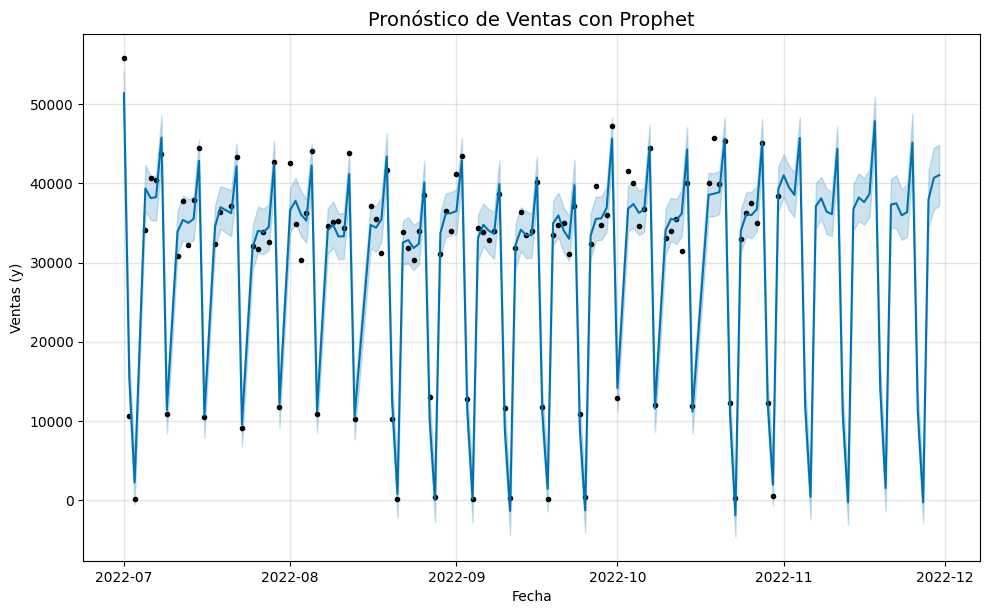

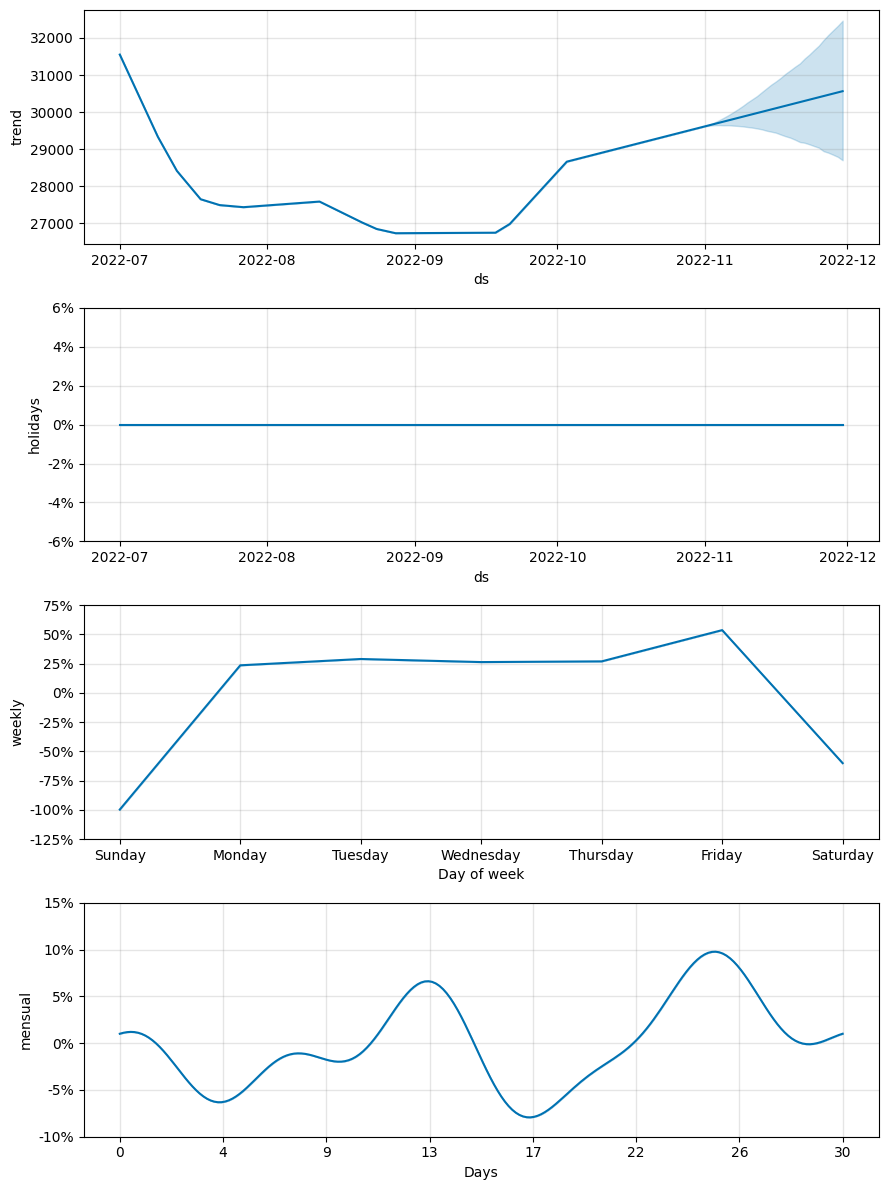

In [103]:
# ===========================================
# 8) GRÁFICAS: PRONÓSTICO Y COMPONENTES
# ===========================================
# Gráfico principal: histórico + pronóstico + bandas de incertidumbre
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas con Prophet", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Ventas (y)")
plt.show()

# Gráfico de componentes: tendencia, estacionalidades (semanal, anual, mensual) y efecto de feriados
fig2 = m.plot_components(forecast)
plt.show()

In [25]:
df.head()

,ds,valor_total,y,valor_total_millones_div5
0,2022-07-01,5.587159e+10,55871.592578,11174.318516
1,2022-07-02,1.056773e+10,10567.733300,2113.546660
2,2022-07-03,1.047493e+08,104.749304,20.949861
3,2022-07-05,3.409717e+10,34097.174855,6819.434971
4,2022-07-06,4.072937e+10,40729.368277,8145.873655


In [21]:
from prophet.diagnostics import cross_validation, performance_metrics

# Validación cruzada: corta la serie en un punto, entrena y prueba
df_cv = cross_validation(
    m,
    initial="90 days",   # periodo inicial de entrenamiento
    period="15 days",    # cada cuánto hacer cortes
    horizon="30 days"    # horizonte de predicción
)

# Métricas
df_p = performance_metrics(df_cv)
print(df_p.head())


INFO:prophet:Making 1 forecasts with cutoffs between 2022-10-01 00:00:00 and 2022-10-01 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmplvednjw8/t6cyq8uk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplvednjw8/c2e7__0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52021', 'data', 'file=/tmp/tmplvednjw8/t6cyq8uk.json', 'init=/tmp/tmplvednjw8/c2e7__0x.json', 'output', 'file=/tmp/tmplvednjw8/prophet_model6f5yakec/prophet_model-20250905012738.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:27:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:27:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0  3 days  2.506955e+07  5006.950597  4882.661969  0.119098  0.119098   
1  4 days  7.455611e+06  2730.496414  2295.729345  0.058886  0.058886   
2  5 days  7.605350e+05   872.086579   870.474578  0.024376  0.024376   
3  6 days  1.525806e+06  1235.235192  1203.155991  0.029219  0.029219   
4  7 days  1.100847e+06  1049.212705   768.289232  0.018908  0.018908   

      smape  coverage  
0  0.127014       0.0  
1  0.061072       0.5  
2  0.024083       1.0  
3  0.028790       1.0  
4  0.018630       1.0  


In [22]:
print(df_p[["horizon","mse", "rmse", "mae", "mape", "coverage"]])

   horizon           mse         rmse          mae      mape  coverage
0   3 days  2.506955e+07  5006.950597  4882.661969  0.119098       0.0
1   4 days  7.455611e+06  2730.496414  2295.729345  0.058886       0.5
2   5 days  7.605350e+05   872.086579   870.474578  0.024376       1.0
3   6 days  1.525806e+06  1235.235192  1203.155991  0.029219       1.0
4   7 days  1.100847e+06  1049.212705   768.289232  0.018908       1.0
5   9 days  1.838576e+06  1355.940907   985.288984  0.031192       1.0
6  10 days  5.901572e+06  2429.315100  2383.977976  0.070861       0.5
7  11 days  5.177618e+06  2275.438063  2171.608565  0.062941       0.5
8  12 days  3.614575e+07  6012.133907  4931.295459  0.154010       0.5
9  13 days  6.753158e+07  8217.759899  8216.313434  0.233487       0.0
10 14 days  3.309002e+07  5752.392429  4574.673817  0.146536       0.5
11 17 days  1.453211e+06  1205.492076  1200.186749  0.062444       1.0
12 18 days  2.979896e+07  5458.842452  4460.312713  0.099474       0.5
13 19 